# Pilot Study: Interaction analysis with DESeq2

## Synposis

In this tutorial, we will illustrate the use of the DESeq2 package for conducting interaction analysis. More specifically, for each gene we will assess the level of statistical evidence to conclude that there is a treatment by strain interaction with respect to the mRNA abudnance for that gene.

## Set Environment

In [1]:
source("pilot_config.R")
source("pilot_util.R")

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
filter(): dplyr, stats
lag():    dplyr, stats

Attaching package: ‘foreach’

The following objects are masked from ‘package:purrr’:

    accumulate, when

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following o

## Load and create data objects

### Attach data objects containing count and meta data

In [2]:
attach(file.path(OUTDIR, "HTS-Pilot-Annotated-STAR-counts.RData"))

### Create columnData object

In [3]:
annomapres0 %>%
    dplyr::filter(enrichment_method == "RZ")  %>%
    DataFrame ->
    columnData
rownames(columnData) <- columnData[["Label"]]

columnData[, c("Label", "Strain", "Media")] %>% head(3)

DataFrame with 3 rows and 3 columns
              Label   Strain    Media
        <character> <factor> <factor>
1_RZ_J       1_RZ_J      H99      YPD
10_RZ_C     10_RZ_C    mar1d      YPD
11_RZ_J     11_RZ_J    mar1d      YPD

### Create countData objects

In [4]:
annogenecnts0 %>%
    dplyr::select(dput(as.character(c("gene", columnData[["Label"]])))) %>%
    as.data.frame %>%
    column_to_rownames("gene") %>%
    as.matrix ->
    countData

countData %>% head(3)

c("gene", "1_RZ_J", "10_RZ_C", "11_RZ_J", "12_RZ_P", "13_RZ_J", 
"14_RZ_C", "15_RZ_C", "16_RZ_P", "2_RZ_C", "21_RZ_C", "22_RZ_C", 
"23_RZ_J", "24_RZ_J", "26_RZ_C", "27_RZ_P", "3_RZ_J", "35_RZ_P", 
"36_RZ_J", "38_RZ_P", "4_RZ_P", "40_RZ_J", "45_RZ_P", "47_RZ_P", 
"9_RZ_C")


,1_RZ_J,10_RZ_C,11_RZ_J,12_RZ_P,13_RZ_J,14_RZ_C,15_RZ_C,16_RZ_P,2_RZ_C,21_RZ_C,⋯,27_RZ_P,3_RZ_J,35_RZ_P,36_RZ_J,38_RZ_P,4_RZ_P,40_RZ_J,45_RZ_P,47_RZ_P,9_RZ_C
CNAG_00001,0,0,0,0,0,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
CNAG_00002,204,76,92,64,230,182,200,129,168,124,⋯,43,107,150,109,95,51,235,122,112,106
CNAG_00003,40,24,18,34,56,53,54,40,40,41,⋯,9,24,26,43,43,11,53,46,41,35


## Interaction Analysis 

Note that the Media by Strain interaction term has been added to the model. In the design argument, the additive model (Median + Strain) has been augmented with the interaction term (Media:Strain). The latter should appear last as it is our primary parameter of interest

In [5]:
ddsmult <- DESeqDataSetFromMatrix(countData, columnData, ~ Media + Strain + Media:Strain)
ddsmult <- estimateSizeFactors(ddsmult)
ddsres <- DESeq(ddsmult)

using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


Verify the design before looking at the results

In [6]:
design(ddsres)

~Media + Strain + Media:Strain

We retrieve the top twenty genes, according to their corresponding adjusted P-values

In [7]:
results(ddsres, tidy=TRUE) %>%
    arrange(padj) %>%
    head(20) ->
    tophits

tophits

row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
CNAG_04307,490.86196,4.0231182,0.29759976,13.518553,1.215429e-41,9.552054e-38
CNAG_05459,636.02477,1.1440422,0.09994094,11.447183,2.429119e-30,9.545224e-27
CNAG_03621,1821.27006,-1.0644341,0.10659585,-9.985699,1.760551e-23,4.612056e-20
CNAG_00600,848.44047,1.1424338,0.11598632,9.849729,6.872879e-23,1.350349e-19
CNAG_04585,812.31911,-4.0407468,0.41261597,-9.792997,1.206656e-22,1.896623e-19
CNAG_03735,521.96604,1.6342312,0.16755798,9.753228,1.786944e-22,2.340599e-19
CNAG_07862,85.91321,-2.6088443,0.26841617,-9.719401,2.492446e-22,2.798304e-19
CNAG_02733,15.32034,-4.0236397,0.41731949,-9.641629,5.333480e-22,5.239478e-19
CNAG_06517,850.38128,1.8719912,0.19539060,9.580764,9.632973e-22,8.411726e-19
CNAG_00399,213.68536,-2.1466008,0.22469243,-9.553507,1.253786e-21,9.853503e-19


Retrieve the gene symbols for the the top and twentieth ranked hits and assign them to the vector topgenes

In [8]:
topgenes <- tophits$row[c(1,20)]
topgenes

[1] "CNAG_04307" "CNAG_05192"

## Visualize Interactions

First, we "normalize" the counts using the vst method (this is an alternative to the rlog method)

In [9]:
vstexp <- vst(ddsmult, blind=TRUE)

A descriptive summary of the results: 

CNAG_0437: For this gene there is seemingly a positive differential expression effect due to treatment (i.e., trt upregulates expression) while the observed direction is reversed in the mar1d strain (i.e., treatment downregulates expression). 

CNAG_04585: Unlike CNAG_0437, treatment seemingly downregulates expression in H99 strain. In the mar1d strain, there is seemingly no treatment effect (or at best a weak one in the same direction as in the H99 strain). What is observed is that the effect size in the H99 is substantially larger than that of the mar1d strain. There is seemingly also an additive effect due to strain (the expressions in the H99 strain are generally higher than those in the mar1d strain)

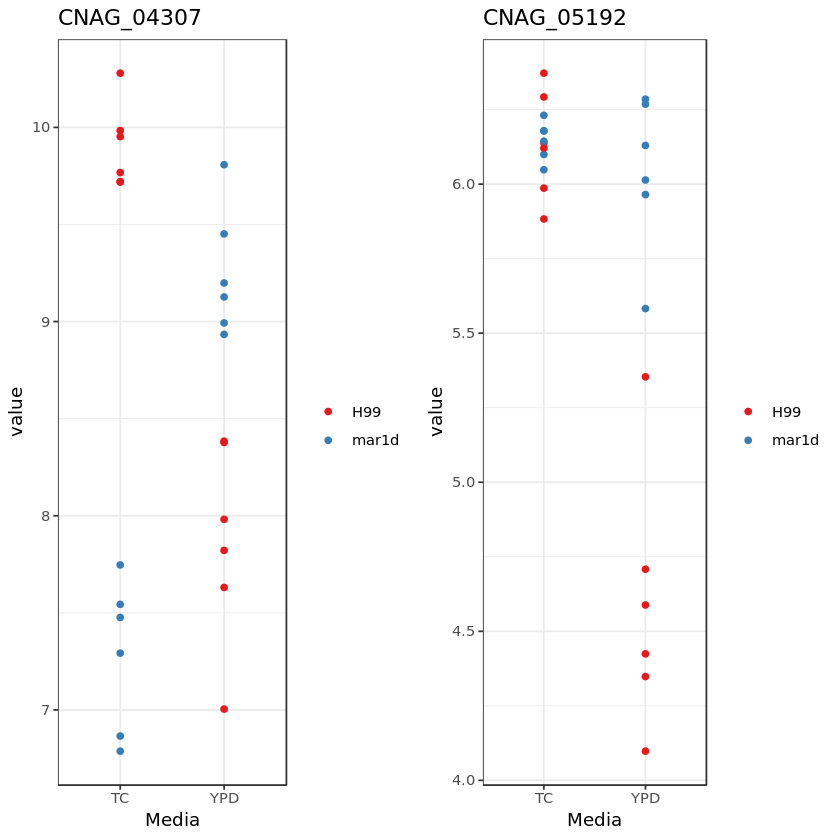

In [10]:
p1 <- myinteractplot(vstexp, topgenes[1], "Label")
p2 <- myinteractplot(vstexp, topgenes[2], "Label")
grid.arrange(p1, p2, ncol = 2) 

## Estimate treatment effect size within each strain

Next, we will show how to estimate treatment effect sizes within each strain. To keep things clean, we make a new copy of the ddsmult object and name it dds. We will add a new variable, to be named group, containing the combined Media and Strain assignments to this new copy and replace its design with group. 

In [11]:
dds <- ddsmult
dds$group <- as.factor(paste0(dds$Media,dds$Strain))
design(dds) <- ~ group
ddsgrp <- DESeq(dds)

using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


Next, we retrieve the results for the top three hits from the interaction analysis (r0), the results for contrasting the treatment effect within H99 (r1) and the results for constrasting the treatment effect within mar1d (r2).

In [12]:
### Results for interaction analysis
r0<-results(ddsres, tidy=TRUE)
### Contrast treatments within H99 strain
r1<-results(ddsgrp, contrast = c("group", "YPDH99", "TCH99"), tidy=TRUE)
### Contrast treatments within mar1d strain
r2<-results(ddsgrp, contrast = c("group", "YPDmar1d", "TCmar1d"), tidy=TRUE)

Now, let's look at the results for the top three genes

In [13]:
### Look at the results for top two genes
r0 %>% filter(row %in% topgenes)
r1 %>% filter(row %in% topgenes)
r2 %>% filter(row %in% topgenes)

row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
CNAG_04307,490.8620,4.023118,0.2975998,13.518553,1.215429e-41,9.552054e-38
CNAG_05192,50.2723,1.859587,0.2446109,7.602225,2.910827e-14,1.143809e-11


row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
CNAG_04307,490.8620,-2.013216,0.2107145,-9.554234,1.245011e-21,9.241900e-20
CNAG_05192,50.2723,-1.953382,0.1997372,-9.779762,1.375341e-22,1.252967e-20


row,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
CNAG_04307,490.8620,2.00990294,0.2101548,9.5639165,1.133828e-21,1.934022e-19
CNAG_05192,50.2723,-0.09379498,0.1412074,-0.6642357,5.065395e-01,5.972830e-01


Descriptive Summary:

CNAG_04307: the estimated fold change is negative in H99 strain while positive in the mar1d strain. This agrees with the observations from the interaction plot. 

CNAG_05192: The estimated fold change in the H99 strain is negative (in the same direction of that for the CNAG-04307 gene). The estimated fold-change in the mar1d group is very small (as observed in the figure). 